In [1]:
import numpy as np
import xgboost as xgb
import yaml

from skimage import io
from sklearn.metrics import jaccard_score, f1_score, auc, precision_recall_curve
from skimage import morphology
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
import PIL

In [2]:
# Increase the limit of allowed images size
PIL.Image.MAX_IMAGE_PIXELS = 10e10

In [3]:
# Set the lame names
lames = ["12AG01290_19", "12AG01290_26", "13AG00043_26"]
slide = "PANCKm-CD8r"
label = "CD8"
min_size = 10

In [4]:
# Load the model file
model = xgb.Booster()
model.load_model(f"models/xgboost_{label}_model.model")

# Set the model to use GPU
model.set_param({'device':'gpu'})

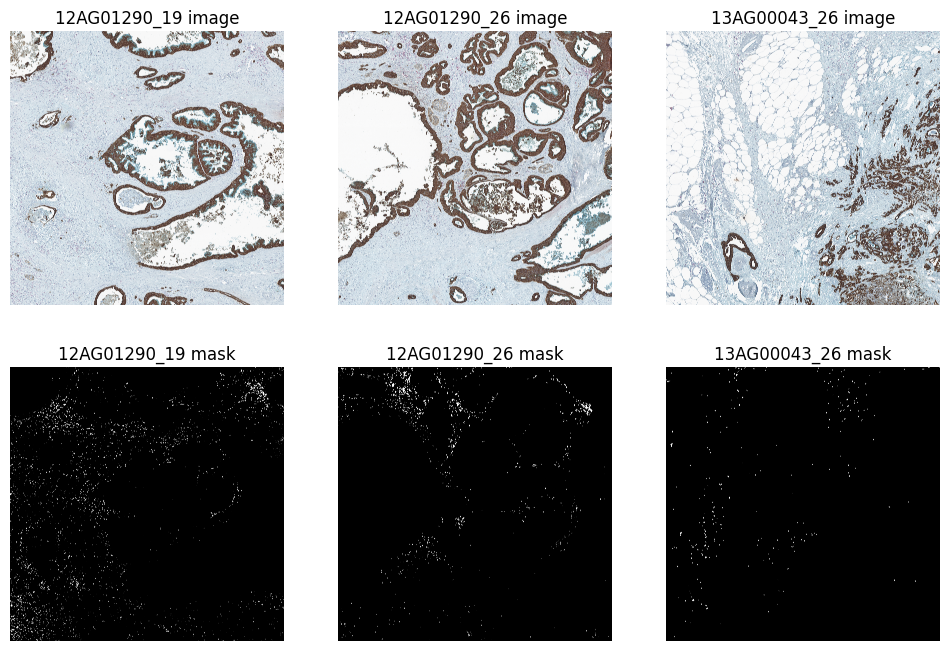

In [5]:
# Define the center and size of the tile
size = 10000

# Plot the image and the mask
fig, ax = plt.subplots(2, len(lames), figsize=(12, 8))

img_tiles, mask_tiles = [], []
for i, lame in enumerate(lames):
    # Load the image and the mask
    img = io.imread(f'data/{lame}/results/images_aligned/{slide}.ome.tiff')
    mask = io.imread(f'data/{lame}/results/masks/{slide}_{label}_mask.png')

    # Determine the center of the image
    center = (img.shape[0]//2, img.shape[1]//2)

    # Take a tile from the image and the mask
    img_tile = img[center[0]-size//2:center[0]+size//2,
                   center[1]-size//2:center[1]+size//2]

    mask_tile = mask[center[0]-size//2:center[0]+size//2,
                     center[1]-size//2:center[1]+size//2]
    
    # Free the memory from the image and the mask
    del img, mask
    
    # Plot the image and the mask
    ax[0, i].imshow(img_tile)
    ax[0, i].set_title(lame + " image")
    ax[0, i].axis('off')

    ax[1, i].imshow(mask_tile, cmap='gray')
    ax[1, i].set_title(lame + " mask")
    ax[1, i].axis('off')

    # Append the tiles to the list
    img_tiles.append(img_tile)
    mask_tiles.append(mask_tile)

In [6]:
# Convert the lists of images and masks into numpy arrays
img_tiles = np.array(img_tiles)
mask_tiles = np.array(mask_tiles)

In [7]:
# pridict the image using the model
dtest = xgb.DMatrix(img_tiles.reshape(-1, 3))
y_score = model.predict(dtest)

In [8]:
# Define the function to optimize
def f1_score_threshold(threshold):
    mask_tiles_pred = y_score.reshape(len(lames), img_tile.shape[0], img_tile.shape[1]) > threshold
    mask_tiles_pred_clean = np.array([morphology.remove_small_objects(mask_tile_pred,
                                                                      min_size=min_size)
                                      for mask_tile_pred in mask_tiles_pred])
    f1 = f1_score(mask_tiles.flatten(), mask_tiles_pred_clean.flatten())
    return -f1

# Optimize the threshold
res = minimize_scalar(fun=f1_score_threshold,
                      bounds=(0, 1),
                      method='bounded')

# Get the best threshold
best_threshold = res.x

print(f"Best threshold: {best_threshold:.4f}")

Best threshold: 0.9586


In [9]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(mask_tiles.flatten(), y_score)

# Compute the AUC
auc_score = auc(recall, precision)

# Calculate the closest threshold to the AUC
# best_threshold = thresholds[np.argmin(np.abs(recall - precision))]

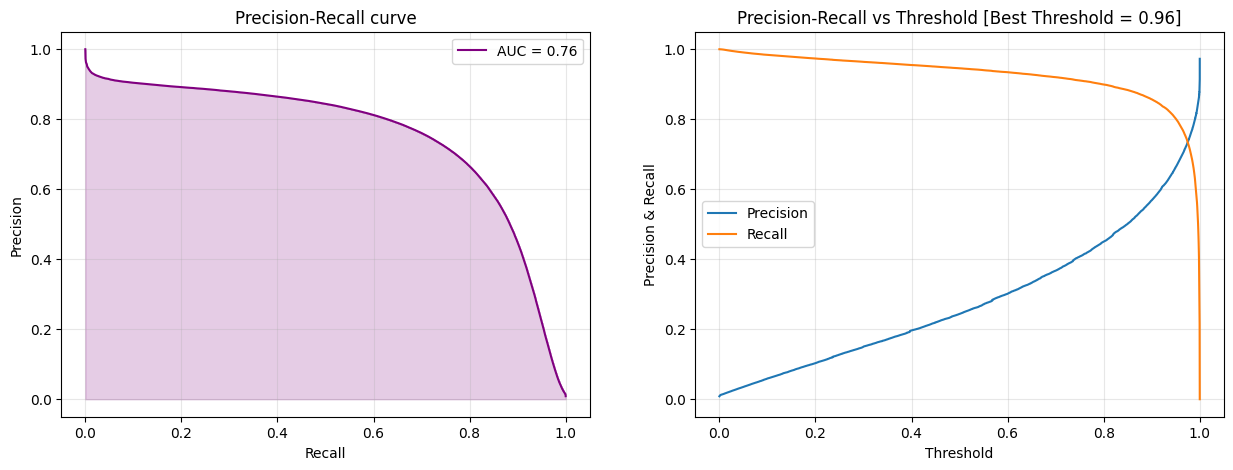

In [10]:
# Plot the precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(recall, precision, color="purple", label=f"AUC = {auc_score:.2f}")
ax[0].fill_between(recall, precision, alpha=0.2, color="purple")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title(f"Precision-Recall curve")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(thresholds, precision[:-1], label="Precision")
ax[1].plot(thresholds, recall[:-1], label="Recall")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Precision & Recall")
ax[1].set_title(f"Precision-Recall vs Threshold [Best Threshold = {best_threshold:.2f}]")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()

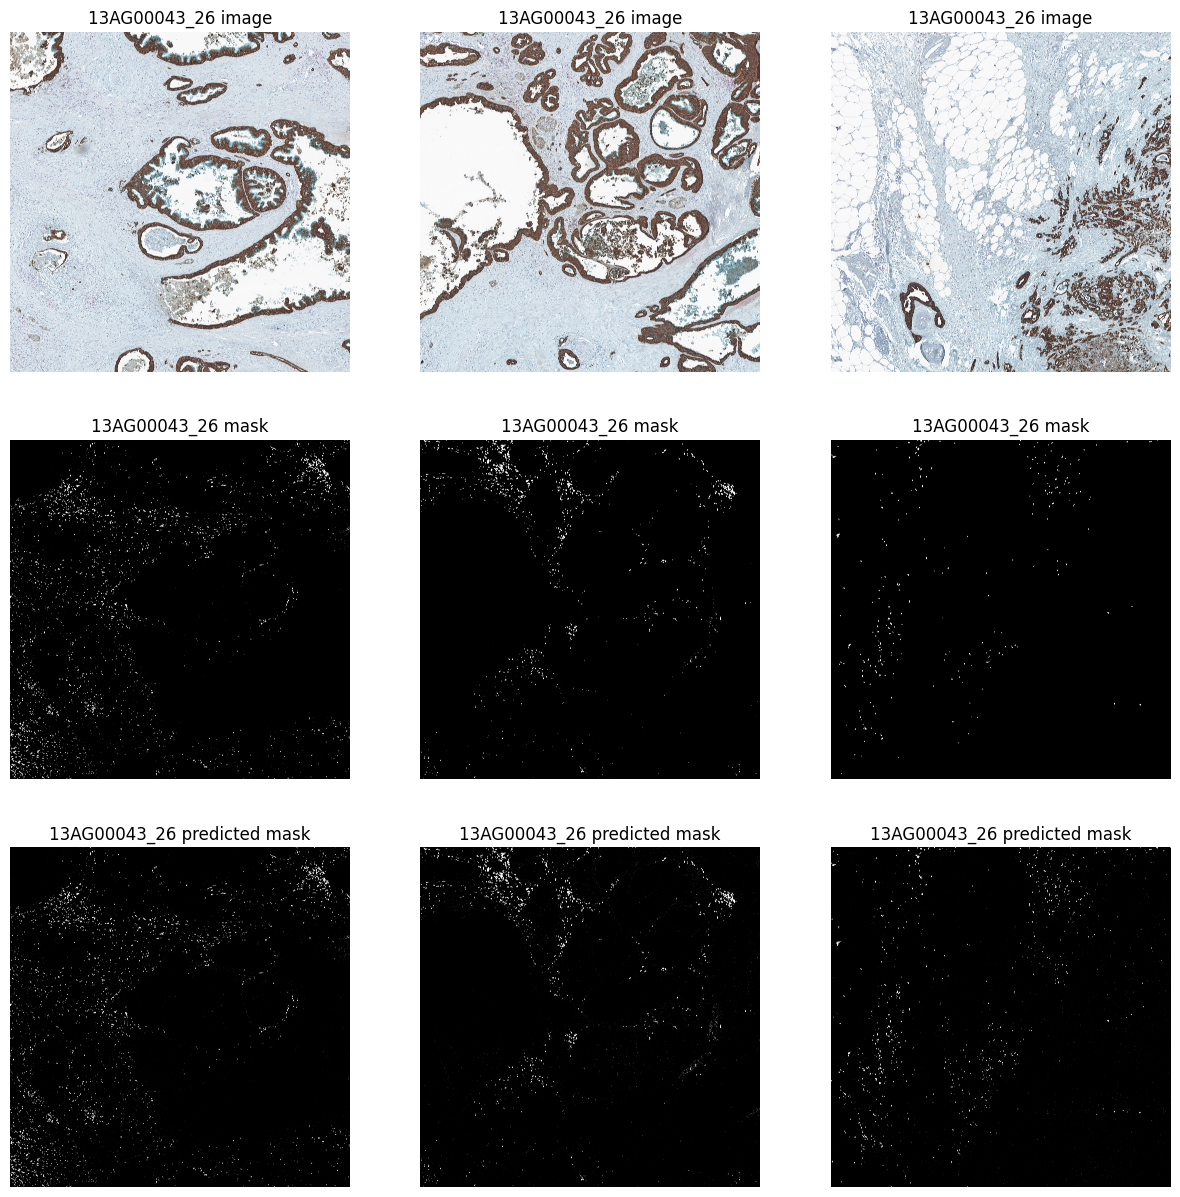

In [11]:
# Binarize the mask using a threshold
mask_tiles_pred = y_score.reshape(len(lames), img_tile.shape[0], img_tile.shape[1]) > best_threshold

# Plot the mask and the predicted mask
fig, ax = plt.subplots(3, len(lames), figsize=(15, 15))
for i, (img_tile, mask_tile, mask_tile_pred) in enumerate(zip(img_tiles, mask_tiles, mask_tiles_pred)):
    ax[0, i].imshow(img_tile)
    ax[0, i].set_title(lame + " image")
    ax[0, i].axis('off')

    ax[1, i].imshow(mask_tile, cmap='gray')
    ax[1, i].set_title(lame + " mask")
    ax[1, i].axis('off')

    ax[2, i].imshow(mask_tile_pred, cmap='gray')
    ax[2, i].set_title(lame + " predicted mask")
    ax[2, i].axis('off')

plt.show()

In [12]:
# Compute the intersection over union
iou = jaccard_score(mask_tiles.flatten(), mask_tiles_pred.flatten())

# Calculate F1 score
f1 = f1_score(mask_tiles.flatten(), mask_tiles_pred.flatten())

print(f"IoU: {iou:.2f}")
print(f"F1 Score: {f1:.2f}")

IoU: 0.58
F1 Score: 0.73


In [13]:
# Clean the mask from small objects
mask_tiles_pred_clean = np.array([morphology.remove_small_objects(mask_tile_pred,
                                                                  min_size=min_size)
                                  for mask_tile_pred in mask_tiles_pred])

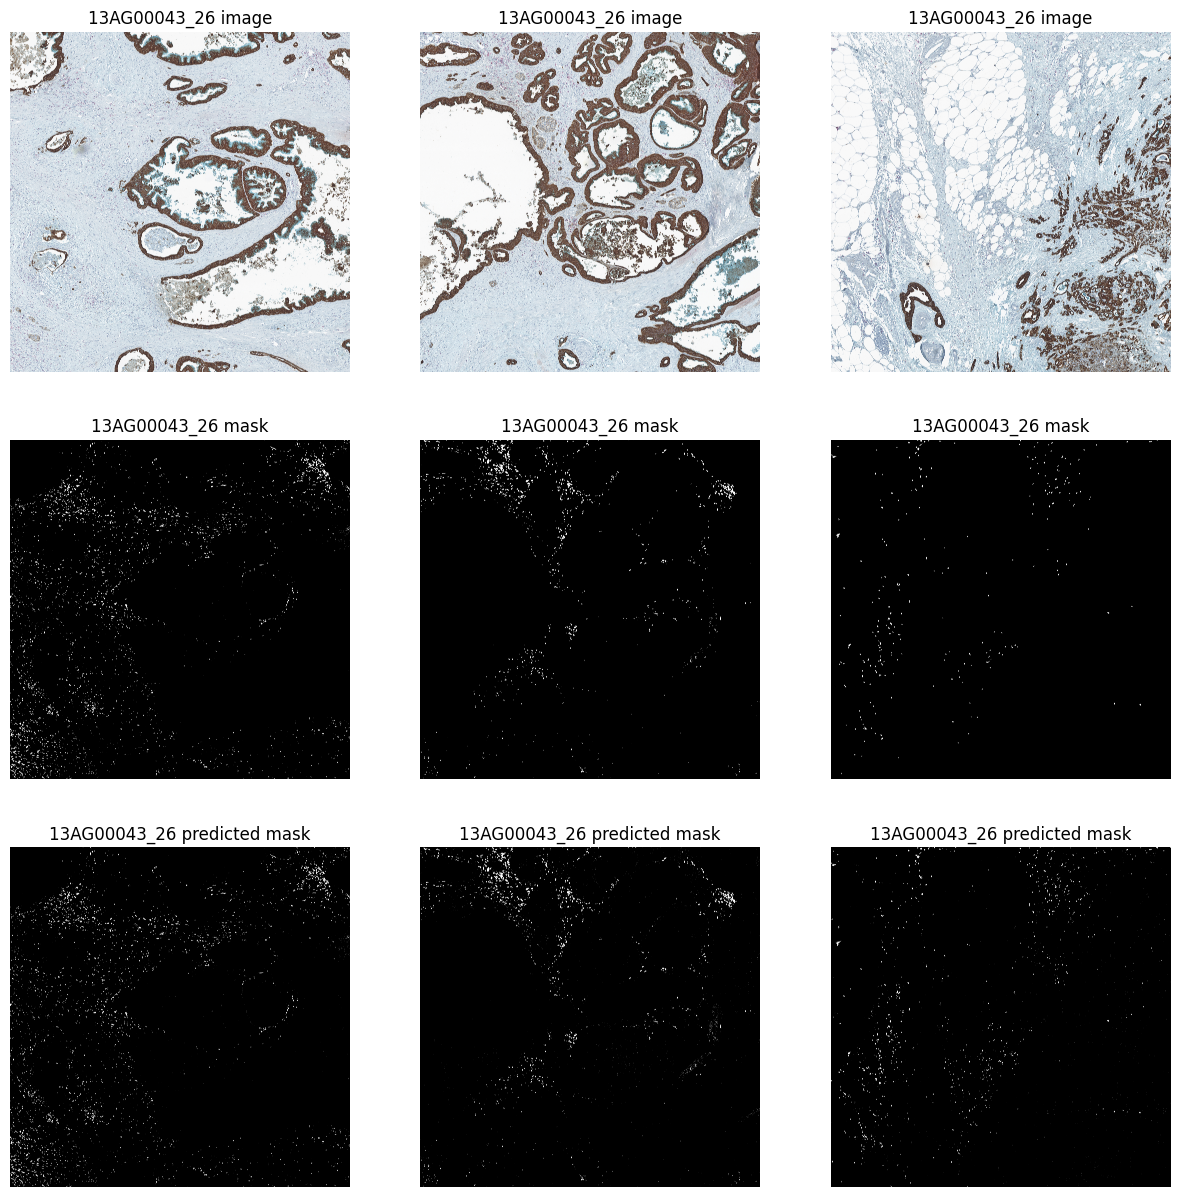

In [14]:
# Plot the mask and the predicted mask
fig, ax = plt.subplots(3, len(lames), figsize=(15, 15))

for i, (img_tile, mask_tile, mask_tile_pred, mask_tile_pred_clean) in enumerate(zip(img_tiles, mask_tiles, mask_tiles_pred, mask_tiles_pred_clean)):
    ax[0, i].imshow(img_tile)
    ax[0, i].set_title(lame + " image")
    ax[0, i].axis('off')

    ax[1, i].imshow(mask_tile, cmap='gray')
    ax[1, i].set_title(lame + " mask")
    ax[1, i].axis('off')

    ax[2, i].imshow(mask_tile_pred_clean, cmap='gray')
    ax[2, i].set_title(lame + " predicted mask")
    ax[2, i].axis('off')

In [15]:
# Compute the intersection over union
iou = jaccard_score(mask_tiles.flatten(), mask_tiles_pred_clean.flatten())

# Calculate F1 score
f1 = f1_score(mask_tiles.flatten(), mask_tiles_pred_clean.flatten())

print(f"IoU: {iou:.2f}")
print(f"F1 score: {f1:.2f}")

IoU: 0.62
F1 score: 0.76


In [16]:
print(f"Relative area before cleaning: {mask_tiles.sum()/ mask_tiles_pred.sum():.2f}")
print(f"Relative area after cleaning: {mask_tiles.sum()/ mask_tiles_pred_clean.sum():.2f}")

Relative area before cleaning: 0.87
Relative area after cleaning: 0.95


In [17]:
# Save the results in yaml file
results = {"threshold": float(best_threshold),
           "iou": float(iou),
           "f1": float(f1),
           "auc": float(auc_score),
           "min_size": int(min_size)}

with open(f"models/xgboost_{label}_evals.yaml", "w") as f:
    yaml.dump(results, f)